In [146]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [2]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [3]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.5#0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 3000
Test set size: 3000


In [4]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [120]:
from bin_and_delta import *

num_bins = 8
min_bin = 0
max_bin = 4

bin_idxs = np.zeros(len(t_x_data))
deltas = np.zeros(len(t_x_data))

for i in range(len(t_x_data)):
    bin_idxs[i], deltas[i] = get_bin_idx_and_delta(num_bins,min_bin,max_bin,t_x_data[i])

In [121]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features #num_bins #num_features

In [122]:
dim1_data_scaled = bin_idxs

def prepare_data(dim1_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x here, no y and theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.9
train_ds,valid_ds = \
prepare_data(dim1_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([2998, 2])
x_train dimensions: torch.Size([2698, 2])
x_valid dimensions: torch.Size([300, 2])
y_data dimensions: torch.Size([2998, 1])
y_train dimensions: torch.Size([2698, 1])
y_valid dimensions: torch.Size([300, 1])


In [131]:
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(2,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,num_bins)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x
        
    #This function takes an input and predicts the class       
    def predict(self,x):
        softm = nn.Softmax(dim=1)
        out = softm(model(X))
        return torch.argmax(out,dim=1)        

In [132]:
#Initialize the model        
model = MyClassifier()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Number of epochs
epochs = 10
#List to store losses
losses = []

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

# dataiter = iter(train_dl)
# X, y = dataiter.next()
# print(y.shape)
# print(y)
# y = y.reshape(len(y))
# print(y.shape)
# y = y.type(torch.LongTensor)

for i in range(epochs):
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, y = data
        
        # Fudging
#         print(y.shape)
#         print(y)
        y = y.reshape(len(y))
#         print(y.shape)
        y = y.type(torch.LongTensor)
        
        #Precit the output for Given input
        y_pred = model(X) #model.forward(X)
    
#         if(i == 5):
#             print(y_pred)

        #Compute Cross entropy loss
        loss = criterion(y_pred,y)
        #Add loss to the list
        losses.append(loss.item())
        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()

In [133]:
print(model.predict(X))
print(y)

tensor([0, 0, 0, 3, 3, 2, 0, 4])
tensor([0, 0, 0, 3, 3, 2, 0, 5])


In [142]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,10)

    def forward(self, xb):
        return self.lin(xb)

net = MyClassifier() #Network()

# train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):  # loop over the dataset multiple times
#     dataiter = iter(train_dl)
#     inputs, labels = dataiter.next()
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0): # TODO - get train_dl to be appropriate
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         inputs, labels = dataiter.next()
        labels = labels.reshape(len(labels))
        labels = labels.type(torch.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

/opt/conda/envs/pose-prediction/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1,    50] loss: 2.282
[1,   100] loss: 2.089
[1,   150] loss: 1.998
[1,   200] loss: 1.916
[1,   250] loss: 1.862
[2,    50] loss: 1.763
[2,   100] loss: 1.743
[2,   150] loss: 1.703
[2,   200] loss: 1.686
[2,   250] loss: 1.658
[3,    50] loss: 1.623
[3,   100] loss: 1.608
[3,   150] loss: 1.531
[3,   200] loss: 1.532
[3,   250] loss: 1.522
[4,    50] loss: 1.457
[4,   100] loss: 1.455
[4,   150] loss: 1.465
[4,   200] loss: 1.407
[4,   250] loss: 1.412
[5,    50] loss: 1.393
[5,   100] loss: 1.391
[5,   150] loss: 1.333
[5,   200] loss: 1.312
[5,   250] loss: 1.285
[6,    50] loss: 1.374
[6,   100] loss: 1.270
[6,   150] loss: 1.243
[6,   200] loss: 1.237
[6,   250] loss: 1.234
[7,    50] loss: 1.203
[7,   100] loss: 1.240
[7,   150] loss: 1.196
[7,   200] loss: 1.202
[7,   250] loss: 1.156
[8,    50] loss: 1.189
[8,   100] loss: 1.221
[8,   150] loss: 1.123
[8,   200] loss: 1.109
[8,   250] loss: 1.119
[9,    50] loss: 1.143
[9,   100] loss: 1.140
[9,   150] loss: 1.125
[9,   200] 

[70,    50] loss: 0.498
[70,   100] loss: 0.465
[70,   150] loss: 0.499
[70,   200] loss: 0.503
[70,   250] loss: 0.472
[71,    50] loss: 0.483
[71,   100] loss: 0.508
[71,   150] loss: 0.435
[71,   200] loss: 0.474
[71,   250] loss: 0.493
[72,    50] loss: 0.520
[72,   100] loss: 0.469
[72,   150] loss: 0.475
[72,   200] loss: 0.492
[72,   250] loss: 0.498
[73,    50] loss: 0.451
[73,   100] loss: 0.469
[73,   150] loss: 0.505
[73,   200] loss: 0.498
[73,   250] loss: 0.452
[74,    50] loss: 0.469
[74,   100] loss: 0.491
[74,   150] loss: 0.463
[74,   200] loss: 0.459
[74,   250] loss: 0.492
[75,    50] loss: 0.475
[75,   100] loss: 0.428
[75,   150] loss: 0.478
[75,   200] loss: 0.511
[75,   250] loss: 0.514
[76,    50] loss: 0.455
[76,   100] loss: 0.526
[76,   150] loss: 0.437
[76,   200] loss: 0.468
[76,   250] loss: 0.501
[77,    50] loss: 0.492
[77,   100] loss: 0.463
[77,   150] loss: 0.505
[77,   200] loss: 0.444
[77,   250] loss: 0.494
[78,    50] loss: 0.492
[78,   100] loss

In [185]:
# from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):
#     print(yb)
    yb = yb.reshape(len(yb))
    yb = yb.type(torch.LongTensor)
    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 30
epochs = 50
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = MyClassifier()
criterion = nn.CrossEntropyLoss()
loss_func = criterion
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


/opt/conda/envs/pose-prediction/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 1.145157927274704
1 0.8815307557582855
2 0.766159999370575
3 0.7125474810600281
4 0.6581001073122025
5 0.6171261802315712
6 0.6023433029651641
7 0.5609966158866883
8 0.5378781244158745
9 0.5364421747624875
10 0.5177577883005142
11 0.5025647535920144
12 0.49846707955002784
13 0.49199232533574105
14 0.49778145402669904
15 0.4666017297655344
16 0.4623149145394564
17 0.481082696467638
18 0.4548159476369619
19 0.4757221847772598
20 0.46160187795758245
21 0.4557272184640169
22 0.46322536915540696
23 0.44512854889035225
24 0.44781266823410987
25 0.4395740248262882
26 0.4473116625100374
27 0.4404549922794104
28 0.44557381980121136
29 0.4352200452238321
30 0.43019784912467
31 0.4500876497477293
32 0.44121579006314277
33 0.4191651545464993
34 0.42170176543295385
35 0.42463562041521075
36 0.4314795911312103
37 0.4193031761795282
38 0.4179803665727377
39 0.4200936544686556
40 0.43014624528586864
41 0.414779769256711
42 0.40898746661841867
43 0.41934161856770513
44 0.4109250869601965
45 0.4070661

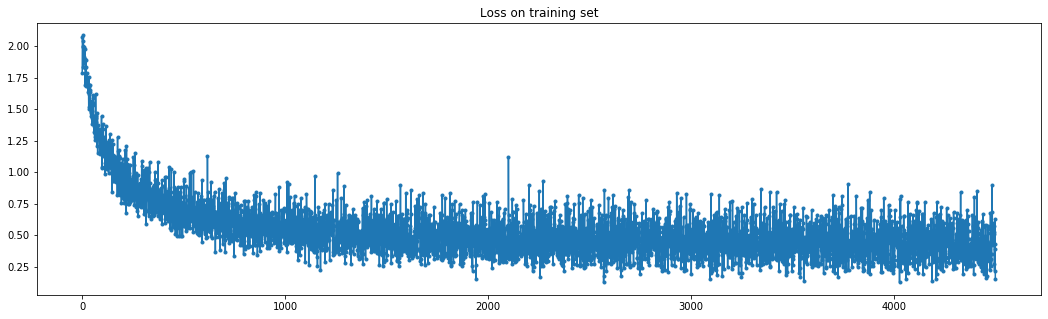

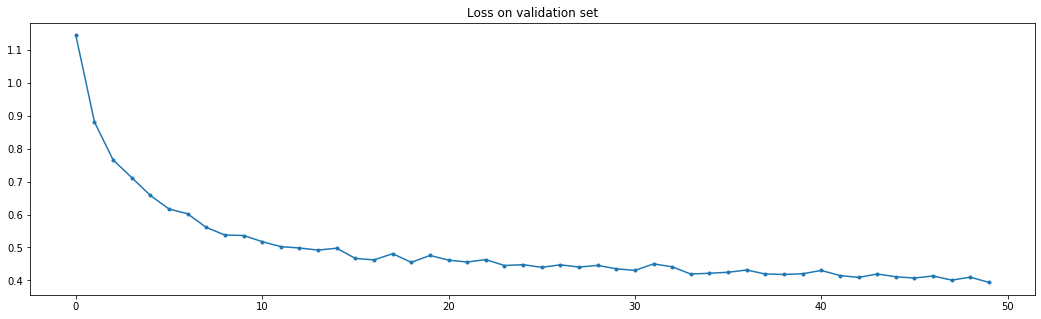

In [186]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')